### Import Packages

In [1]:
import pickle
# from ident import Ident

from gekko import GEKKO
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### Import Data

In [2]:
with open('models.pkl', 'rb') as file:
    models = pickle.load(file)
    
df = pd.read_excel('data/data_mod.xlsx')
df.drop(columns=['Unnamed: 0'], inplace=True)

# df[['RW']] = df[['CW']].to_numpy() - df[['IW']].to_numpy() - df[['SW']].to_numpy()

In [3]:
# model = models['D']
# na = model.na_best
# nb = model.nb_best
# nk = model.nk_best
# n = max(na, nb, nk)

In [4]:
# sl[P:] = sl_past
# cw[P:] = cw_past
# cs[P:] = cs_past
# d[P:] = d_past
# cp[P:] = cp_past
# l[P:] = l_past
# p[P:] = p_past
# rw[P:] = rw_past
# g[P:] = g_past

### Create MPC Controller/Model

In [5]:
class Cont(GEKKO):
    def __init__(self, P=1, M=1, n_max=10, p0=20, *args, **kwargs):
        self.P = P
        self.M = M
        self.MVs = ['F', 'WR', 'IW', 'S', 'SW', 'NC', 'CL']
        self.CVs = ['CS', 'CW', 'P', 'L', 'SL', 'CP', 'D', 'G', 'RW']
        # self.CVs = ['CS', 'CW', 'P', 'L', 'SL', 'CP', 'D']

        self.mv_result = {}
        self.cv_result = {}
        
        super().__init__(remote=False, *args, **kwargs)
        P = self.P
        M = self.M

        p0 = p0
        n_max = n_max
        
        cv_dict = {}
        mv_dict = {}

        for cv_i in self.CVs:
            cv_dict[cv_i] = np.append(self.Array(self.CV, P), self.Array(self.Param, n_max))
            self.cv_result[cv_i] = []
            
        cv_dict['RW'] = np.append(self.Array(self.CV, P), self.Array(self.Param, n_max))
            
        for mv_i in self.MVs:
            self.mv_result[mv_i] = []
            try:
                if mv_i == 'NC':
                    mv_dict[mv_i] = np.append(self.Array(self.MV, M, integer=True), self.Array(self.Param, n_max))
                else:
                    mv_dict[mv_i] = np.append(self.Array(self.MV, M), self.Array(self.Param, n_max))
            except:
                mv_dict[mv_i] = self.Array(self.Param, n_max)

        for i in range(P):
            self.Equation(cv_dict['RW'][P-i-1]==cv_dict['CW'][P-i-1]-(mv_dict['IW'][P-i-1]+mv_dict['SW'][P-i-1]))

            self.Equation(cv_dict['SL'][P-i-1] == models['SL'].alpha['SL'].dot(cv_dict['SL'][P-i:P-i+models['SL'].na_best]) + 
                                       models['SL'].beta['WR'].dot(mv_dict['WR'][P-i-1+models['SL'].nk_best:P-i+models['SL'].nb_best-1+models['SL'].nk_best]) + 
                                       models['SL'].beta['SW'].dot(mv_dict['SW'][P-i-1+models['SL'].nk_best:P-i+models['SL'].nb_best-1+models['SL'].nk_best]) + 
                                       models['SL'].beta['CL'].dot(mv_dict['CL'][P-i-1+models['SL'].nk_best:P-i+models['SL'].nb_best-1+models['SL'].nk_best]) +
                                       models['SL'].beta['L'].dot(cv_dict['L'][P-i+models['SL'].nk_best:P-i+models['SL'].nb_best+models['SL'].nk_best]) + 
                                       models['SL'].beta['CS'].dot(cv_dict['CS'][P-i+models['SL'].nk_best:P-i+models['SL'].nb_best+models['SL'].nk_best]) + 
                                       models['SL'].gamma[0])

            self.Equation(cv_dict['CW'][P-i-1] == models['CW'].alpha['CW'].dot(cv_dict['CW'][P-i:P-i+models['CW'].na_best]) + 
                                       models['CW'].beta['F'].dot(mv_dict['F'][P-i-1+models['CW'].nk_best:P-i+models['CW'].nb_best-1+models['CW'].nk_best]) + 
                                       models['CW'].beta['IW'].dot(mv_dict['IW'][P-i-1+models['CW'].nk_best:P-i+models['CW'].nb_best-1+models['CW'].nk_best]) +
                                       models['CW'].beta['G'].dot(cv_dict['G'][P-i+models['CW'].nk_best:P-i+models['CW'].nb_best+models['CW'].nk_best]) + 
                                       models['CW'].gamma[0])

            self.Equation(cv_dict['CS'][P-i-1] == models['CS'].alpha['CS'].dot(cv_dict['CS'][P-i:P-i+models['CS'].na_best]) + 
                                       models['CS'].beta['WR'].dot(mv_dict['WR'][P-i-1+models['CS'].nk_best:P-i+models['CS'].nb_best-1+models['CS'].nk_best]) + 
                                       models['CS'].beta['SW'].dot(mv_dict['SW'][P-i-1+models['CS'].nk_best:P-i+models['CS'].nb_best-1+models['CS'].nk_best]) + 
                                       models['CS'].beta['CL'].dot(mv_dict['CL'][P-i-1+models['CS'].nk_best:P-i+models['CS'].nb_best-1+models['CS'].nk_best]) +
                                       models['CS'].beta['NC'].dot(mv_dict['NC'][P-i-1+models['CS'].nk_best:P-i+models['CS'].nb_best-1+models['CS'].nk_best]) + 
                                       models['CS'].beta['L'].dot(cv_dict['L'][P-i+models['CS'].nk_best:P-i+models['CS'].nb_best+models['CS'].nk_best]) + 
                                       models['CS'].beta['SL'].dot(cv_dict['SL'][P-i+models['CS'].nk_best:P-i+models['CS'].nb_best+models['CS'].nk_best]) + 
                                       models['CS'].beta['CP'].dot(cv_dict['CP'][P-i+models['CS'].nk_best:P-i+models['CS'].nb_best+models['CS'].nk_best]) + 
                                       models['CS'].gamma[0])

            self.Equation(cv_dict['D'][P-i-1] == models['D'].alpha['D'].dot(cv_dict['D'][P-i:P-i+models['D'].na_best]) + 
                                      models['D'].beta['F'].dot(mv_dict['F'][P-i-1+models['D'].nk_best:P-i+models['D'].nb_best-1+models['D'].nk_best]) + 
                                      models['D'].beta['IW'].dot(mv_dict['IW'][P-i-1+models['D'].nk_best:P-i+models['D'].nb_best-1+models['D'].nk_best]) + 
                                      models['D'].beta['S'].dot(mv_dict['S'][P-i-1+models['D'].nk_best:P-i+models['D'].nb_best-1+models['D'].nk_best]) + 
                                      models['D'].beta['P'].dot(cv_dict['P'][P-i+models['D'].nk_best:P-i+models['D'].nb_best+models['D'].nk_best]) + 
                                      models['D'].gamma[0])

            self.Equation(cv_dict['CP'][P-i-1]== models['CP'].alpha['CP'].dot(cv_dict['CP'][P-i:P-i+models['CP'].na_best]) + 
                                      models['CP'].beta['WR'].dot(mv_dict['WR'][P-i-1+models['CP'].nk_best:P-i+models['CP'].nb_best-1+models['CP'].nk_best]) + 
                                      models['CP'].beta['SW'].dot(mv_dict['SW'][P-i-1+models['CP'].nk_best:P-i+models['CP'].nb_best-1+models['CP'].nk_best]) + 
                                      models['CP'].beta['CL'].dot(mv_dict['CL'][P-i-1+models['CP'].nk_best:P-i+models['CP'].nb_best-1+models['CP'].nk_best]) +
                                      models['CP'].beta['NC'].dot(mv_dict['NC'][P-i-1+models['CP'].nk_best:P-i+models['CP'].nb_best-1+models['CP'].nk_best]) + 
                                      models['CP'].beta['L'].dot(cv_dict['L'][P-i+models['CP'].nk_best:P-i+models['CP'].nb_best+models['CP'].nk_best]) + 
                                      models['CP'].beta['SL'].dot(cv_dict['SL'][P-i+models['CP'].nk_best:P-i+models['CP'].nb_best+models['CP'].nk_best]) + 
                                      models['CP'].beta['CS'].dot(cv_dict['CS'][P-i+models['CP'].nk_best:P-i+models['CP'].nb_best+models['CP'].nk_best]) + 
                                      models['CP'].gamma[0])

            self.Equation(cv_dict['L'][P-i-1] == models['L'].alpha['L'].dot(cv_dict['L'][P-i:P-i+models['L'].na_best]) + 
                                      models['L'].beta['WR'].dot(mv_dict['WR'][P-i-1+models['L'].nk_best:P-i+models['L'].nb_best-1+models['L'].nk_best]) + 
                                      models['L'].beta['SW'].dot(mv_dict['SW'][P-i-1+models['L'].nk_best:P-i+models['L'].nb_best-1+models['L'].nk_best]) + 
                                      models['L'].beta['CL'].dot(mv_dict['CL'][P-i-1+models['L'].nk_best:P-i+models['L'].nb_best-1+models['L'].nk_best]) +
                                      models['L'].beta['NC'].dot(mv_dict['NC'][P-i-1+models['L'].nk_best:P-i+models['L'].nb_best-1+models['L'].nk_best]) + 
                                      models['L'].beta['CP'].dot(cv_dict['CP'][P-i+models['L'].nk_best:P-i+models['L'].nb_best+models['L'].nk_best]) + 
                                      models['L'].beta['SL'].dot(cv_dict['SL'][P-i+models['L'].nk_best:P-i+models['L'].nb_best+models['L'].nk_best]) + 
                                      models['L'].beta['CS'].dot(cv_dict['CS'][P-i+models['L'].nk_best:P-i+models['L'].nb_best+models['L'].nk_best]) + 
                                      models['L'].gamma[0])

            self.Equation(cv_dict['P'][P-i-1] == models['P'].alpha['P'].dot(cv_dict['P'][P-i:P-i+models['P'].na_best]) + 
                                      models['P'].beta['F'].dot(mv_dict['F'][P-i-1+models['P'].nk_best:P-i+models['P'].nb_best-1+models['P'].nk_best]) + 
                                      models['P'].beta['IW'].dot(mv_dict['IW'][P-i-1+models['P'].nk_best:P-i+models['P'].nb_best-1+models['P'].nk_best]) + 
                                      models['P'].beta['S'].dot(mv_dict['S'][P-i-1+models['P'].nk_best:P-i+models['P'].nb_best-1+models['P'].nk_best]) + 
                                      models['P'].beta['D'].dot(cv_dict['D'][P-i+models['P'].nk_best:P-i+models['P'].nb_best+models['P'].nk_best]) +
                                      models['P'].gamma[0])

            self.Equation(cv_dict['G'][P-i-1] == models['G'].alpha['G'].dot(cv_dict['G'][P-i:P-i+models['G'].na_best]) + 
            #                           models['G'].beta['F'].dot(mv_dict['F'][P-i-1+models['G'].nk_best:P-i+models['G'].nb_best-1+models['G'].nk_best]) + 
            #                           models['G'].beta['WR'].dot(mv_dict['IW'][P-i-1+models['G'].nk_best:P-i+models['G'].nb_best-1+models['G'].nk_best]/
            #                                                      mv_dict['F'][P-i-1+models['G'].nk_best:P-i+models['G'].nb_best-1+models['G'].nk_best]) +
            #                           models['G'].beta['IW'].dot(mv_dict['IW'][P-i-1+models['G'].nk_best:P-i+models['G'].nb_best-1+models['G'].nk_best]) +
            #                           models['G'].beta['S'].dot(mv_dict['S'][P-i-1+models['G'].nk_best:P-i+models['G'].nb_best-1+models['G'].nk_best]) +
            #                           models['G'].beta['SW'].dot(mv_dict['SW'][P-i-1+models['G'].nk_best:P-i+models['G'].nb_best-1+models['G'].nk_best]) +
            #                           models['G'].beta['NC'].dot(mv_dict['NC'][P-i-1+models['G'].nk_best:P-i+models['G'].nb_best-1+models['G'].nk_best]) +
            #                           models['G'].beta['CL'].dot(mv_dict['CL'][P-i-1+models['G'].nk_best:P-i+models['G'].nb_best-1+models['G'].nk_best]) +
            #                           models['G'].beta['CS'].dot(cv_dict['CS'][P-i+models['G'].nk_best:P-i+models['G'].nb_best-1+models['G'].nk_best]) +
                                      models['G'].beta['CW'].dot(cv_dict['CW'][P-i+models['G'].nk_best:P-i+models['G'].nb_best+models['G'].nk_best]) +
            #                           models['G'].beta['P'].dot(cv_dict['P'][P-i+models['G'].nk_best:P-i+models['G'].nb_best-1+models['G'].nk_best]) +
            #                           models['G'].beta['L'].dot(cv_dict['L'][P-i+models['G'].nk_best:P-i+models['G'].nb_best-1+models['G'].nk_best]) +
            #                           models['G'].beta['SL'].dot(cv_dict['SL'][P-i+models['G'].nk_best:P-i+models['G'].nb_best-1+models['G'].nk_best]) +
            #                           models['G'].beta['CP'].dot(cv_dict['CP'][P-i+models['G'].nk_best:P-i+models['G'].nb_best-1+models['G'].nk_best]) +
                                      models['G'].beta['RW'].dot(cv_dict['RW'][P-i+models['G'].nk_best:P-i+models['G'].nb_best+models['G'].nk_best]) +
            #                           models['G'].beta['D'].dot(cv_dict['D'][P-i+models['G'].nk_best:P-i+models['G'].nb_best-1+models['G'].nk_best]) +
                                      models['G'].gamma[0])
            

        self.f = mv_dict['F']
        self.wr = mv_dict['WR']
        self.iw = mv_dict['IW']
        self.s = mv_dict['S']
        self.sw = mv_dict['SW']
        self.nc = mv_dict['NC']
        self.cl = mv_dict['CL']
        
        self.cs = cv_dict['CS']
        self.cw = cv_dict['CW']
        self.p = cv_dict['P']
        self.l = cv_dict['L']
        self.sl = cv_dict['SL']
        self.cp = cv_dict['CP']
        self.d = cv_dict['D']
        self.g = cv_dict['G']
        
        self.mv_dict = mv_dict
        self.cv_dict = cv_dict
        
        self.options.IMODE = 2

        
    # def ss_run(self):
    #     self.options.IMODE = 1
    #     self.solve(disp=False)
        
    def update_model(self, mv_dict_new, cv_dict_new):
        for mv_i in self.MVs:
            for ind, val in enumerate(mv_dict_new[mv_i]):
                self.mv_dict[mv_i][ind+self.M].value = val
            
        for cv_i in self.CVs:
            for ind, val in enumerate(cv_dict_new[cv_i]):
                self.cv_dict[cv_i][ind+self.P].value = val
                
        for ind, val in enumerate(cv_dict_new['RW']):
            self.cv_dict['RW'][ind+self.P].value = val
    
    def get_results(self):
        for cv_i in self.CVs:
            self.cv_result[cv_i].append(self.cv_dict[cv_i][self.P-1].value[0])
        self.cv_result['RW'].append(self.cv_dict['RW'][self.P-1].value[0])    
        for mv_i in self.MVs:
            self.mv_result[mv_i].append(self.mv_dict[mv_i][self.M-1].value[0])
        


### Setup Controller + Run Controller

In [29]:
MV = ['F', 'WR', 'IW', 'S', 'SW', 'NC', 'CL']
# CV = ['CS', 'CW', 'P', 'L', 'SL', 'CP', 'D', 'RW']
CV = ['CS', 'CW', 'P', 'L', 'SL', 'CP', 'D', 'G', 'RW']

P = 1
M = 1

p0 = 20
n_max = 10

mv_past = {}
cv_past = {}

lim_dict = {
#     CV
    'CS': [1000, 6500],
    'CW': [1000, 5000],
    'P': [10, 16],
    'L': [800, 950],
    'SL': [60, 80],
    'CP': [60, 100],
    'D': [1.5, 1.8],
    'RW': [500, 2500],
    'G': [40, 55],
#     MV
    'F': [750, 1500],
    'WR': [0.25, 0.75],
    'IW': [450, 750],
    'S': [5, 14],
    'SW': [500, 950],
    'NC': [4, 9],
    'CL': [2000, 7000],
}

# wsp_dict = {
#     'CS': 1,
#     'CW': 1,
#     'P': 200,
#     'L': 5,
#     'SL': 40,
#     'CP': 30,
#     'D': 300,
#     'RW': 6000,
#     'G': 100
# }
sp_dict = {
    'CS': 3300,
    'CW': 2700,
    'P': 15.0,
    'L': 850.0,
    'SL': 75.0,
    'CP': 70.0,
    'D': 1.7,
    'RW': 790,
    'G': 46.0
}
wsp_dict = {
    'CS': 0,
    'CW': 0,
    'P': 100,
    'L': 100,
    'SL': 20,
    'CP': 20,
    'D': 20,
    'RW': 0,
    'G': 100
}

cont = Cont(P=P, M=M, n_max=n_max, p0=p0)
for mv_i in MV:
    for i in range(M):
        # cont.mv_dict[mv_i][i].value = cont.mv_dict[mv_i][M].value
        cont.mv_dict[mv_i][i].STATUS = 1
        # cont.mv_dict[mv_i][i].DMAX = 10
        # cont.mv_dict[mv_i][i].DCOST = 0.01
        # cont.mv_dict[mv_i][i].LOWER = df[mv_i].min()
        # cont.mv_dict[mv_i][i].UPPER = df[mv_i].max()
        cont.mv_dict[mv_i][i].LOWER = lim_dict[mv_i][0]
        cont.mv_dict[mv_i][i].UPPER = lim_dict[mv_i][1]
    
for cv_i in CV:
    for i in range(P):
        # cont.cv_dict[cv_i][i].value = cont.cv_dict[cv_i][P].value
        if (cv_i == 'CW') or (cv_i == 'CS') or (cv_i == 'RW'):
            cont.cv_dict[cv_i][i].SPLO = None
            cont.cv_dict[cv_i][i].SPHI = None
        else:
            cont.cv_dict[cv_i][i].STATUS = 1
            cont.cv_dict[cv_i][i].SPLO = lim_dict[cv_i][0]
            cont.cv_dict[cv_i][i].SPHI = lim_dict[cv_i][1]
            cont.cv_dict[cv_i][i].WSP = wsp_dict[cv_i]
            cont.cv_dict[cv_i][i].SP = (lim_dict[cv_i][0] + lim_dict[cv_i][1])/2
        # cont.cv_dict['G'][i].SP = 45
        # cont.cv_dict['SL'][i].SP = 70
        # cont.cv_dict['L'][i].SP = 863

        # cont.cv_dict[cv_i][i].SPLO = df[cv_i].iloc[:20].min()
        # cont.cv_dict[cv_i][i].SPHI = df[cv_i].iloc[:20].max()
        # cont.cv_dict[cv_i][i].SP = df[cv_i].iloc[:20].mean()
        # cont.cv_dict[cv_i][i].WSP = wsp_dict[cv_i]

for i in range(n_max):
    cont.cv_dict['RW'][P+i].value = cont.cv_dict['RW'][P+i].value - (cont.mv_dict['IW'][P+i].value+cont.mv_dict['SW'][P+i].value)        

cont.options.IMODE = 3
# cont.options.SOLVER = 2
cont.CV_TYPE = 1

# cont.Minimize(sum(abs(cont.sl-66)))
# cont.ss_run()
run_steps = 600
yp = []

for k in range(run_steps):
    if k == 0: 
        for mv_i in MV:
            mv_past[mv_i] = df[[mv_i]].iloc[p0+k:p0-n_max+k:-1].to_numpy().flatten()
        for cv_i in CV:
            cv_past[cv_i] = df[[cv_i]].iloc[p0+k-1:p0-n_max+k-1:-1].to_numpy().flatten()
    else:
        for mv_i in MV:
            mv_past[mv_i] = [val.value[0] for val in cont.mv_dict[mv_i][M-1:n_max+M-1]]
        for cv_i in CV:
            cv_past[cv_i] = [val.value[0] for val in cont.cv_dict[cv_i][P-1:n_max+P-1]]

    cont.update_model(mv_past, cv_past)
    
    # for mv_i in MV:
    #     for i in range(M):
    #         cont.mv_dict[mv_i][i].value = cont.mv_dict[mv_i][M].value
    # if k == 300:
    #     cont.cv_dict['G'][0].SP = 45.0
    #     cont.cv_dict['G'][0].SPLO = 44.8
    #     cont.cv_dict['G'][0].SP = 45.2
    cont.solve(disp=False)
#     if cont.options.APPINFO!=0:
#         print('Solver error, looking at APPINFO')
#     if cont.options.APPINFO==1:
#         print('APPINFO=1')
#     elif cont.options.APPINFO==2:
#         print('APPINFO=2')
    
    cont.get_results()
    
    cont.clear_data()




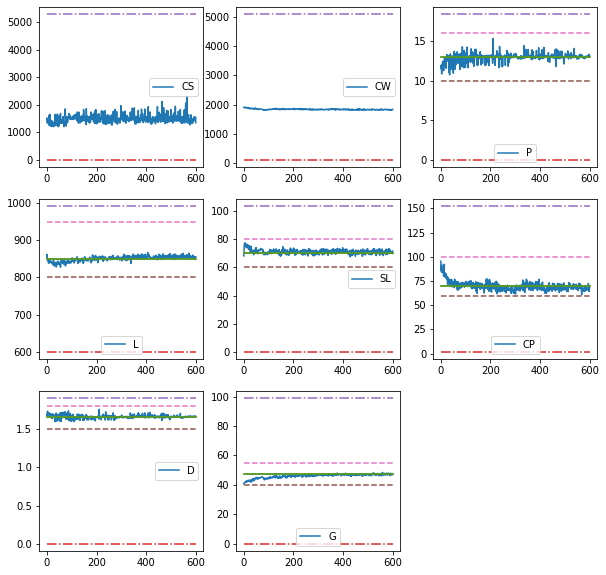

In [33]:
plt.figure(figsize=(10,10))

for ind, cv_i in enumerate(CV):
    if cv_i == 'RW':
        continue
    plt.subplot(3,3,ind+1)
    plt.plot(cont.cv_result[cv_i], label=cv_i)
    try:
        plt.plot([0, len(cont.cv_result[cv_i])], [cont.cv_dict[cv_i][0].SP, cont.cv_dict[cv_i][0].SP])
        plt.plot([0, len(cont.cv_result[cv_i])], [cont.cv_dict[cv_i][0].SP, cont.cv_dict[cv_i][0].SP])

    except:
        pass
    plt.plot([0, len(cont.cv_result[cv_i])], [df[cv_i].min(), df[cv_i].min()], '-.')
    plt.plot([0, len(cont.cv_result[cv_i])], [df[cv_i].max(), df[cv_i].max()], '-.')
    
    plt.plot([0, len(cont.cv_result[cv_i])], [cont.cv_dict[cv_i][0].SPLO, cont.cv_dict[cv_i][0].SPLO], '--')
    plt.plot([0, len(cont.cv_result[cv_i])], [cont.cv_dict[cv_i][0].SPHI, cont.cv_dict[cv_i][0].SPHI], '--')
    
    plt.legend()

In [1]:
cont.cv_dict['L'][0].SP = 850
cont.cv_dict['CP'][0].SP = 70


NameError: name 'cont' is not defined

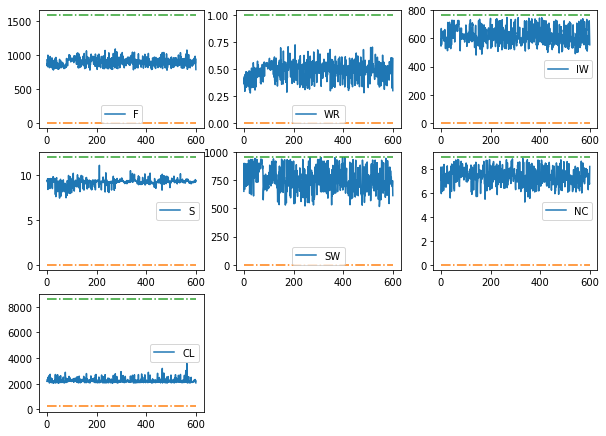

In [32]:
plt.figure(figsize=(10,10))

for ind, mv_i in enumerate(MV):
    plt.subplot(4,3,ind+1)
    plt.plot(cont.mv_result[mv_i], label=mv_i)
    # plt.plot([0, len(cont.mv_result[mv_i])], [df[mv_i].mean(), df[mv_i].mean()])
    
    plt.plot([0, len(cont.mv_result[mv_i])], [df[mv_i].min(), df[mv_i].min()], '-.')
    plt.plot([0, len(cont.mv_result[mv_i])], [df[mv_i].max(), df[mv_i].max()], '-.')

    # plt.plot([0, len(cont.mv_result[mv_i])], [cont.mv_dict[mv_i][0].LOWER, cont.mv_dict[mv_i][0].LOWER], '--')
    # plt.plot([0, len(cont.mv_result[mv_i])], [cont.mv_dict[mv_i][0].UPPER, cont.mv_dict[mv_i][0].UPPER], '--')
    plt.legend()

In [35]:
cont.cv_result['L']

[856.30397602,
 861.9466208,
 848.23869544,
 845.98347342,
 849.16899612,
 843.93622647,
 841.1091472,
 838.55411402,
 838.71731232,
 838.92601342,
 846.22010435,
 844.98198529,
 839.48939062,
 845.73011485,
 844.87484963,
 842.49076136,
 844.20431672,
 842.1038639,
 840.34041953,
 841.32936379,
 841.08970867,
 838.40229567,
 839.29234453,
 836.42616488,
 834.44204945,
 838.80837019,
 843.98609305,
 846.83292555,
 842.69664992,
 838.0107634,
 830.53687431,
 835.35346766,
 840.15130518,
 840.00753037,
 840.07749194,
 837.75052791,
 836.32304879,
 835.16160243,
 827.98416006,
 830.05563657,
 838.35120749,
 837.54151363,
 841.62486532,
 834.91241476,
 841.43276582,
 844.06562419,
 840.31522558,
 840.57890697,
 839.54607413,
 838.50452612,
 834.56824064,
 839.41154369,
 836.53167457,
 840.69071099,
 833.26423696,
 827.59149347,
 833.37364043,
 839.43407006,
 845.57781024,
 843.2463607,
 845.42296912,
 840.31120725,
 842.12195431,
 839.26738472,
 841.14923759,
 846.21583558,
 840.12879004,


In [36]:
cont.cv_dict['L'][0].SP


850

In [8]:
cont.cv_dict['G'][0]

[47.009771867]

In [34]:
with open('results.pkl', 'wb') as file:
    pickle.dump([cont.mv_result, cont.cv_result, cont.mv_dict, cont.cv_dict, df], file)

In [ ]:
plt.savefig()